# Serie (redmpomm) Somo

In [11]:
from api_somo import APIClient, fetch_qf 
import logging
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Configuración del logger
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

api_url = "http://127.0.0.1:8000/database/functions/time-series/filter_date_serie/"
params = {
    "station_name": "gorgona",
    "variable_name": "Precipitación acumulada",
    "processing_level_name": "Control de calidad",
    "start_date": "2009-01-01",
    "end_date": "2023-12-31"
}

try:
    # 1. Solicitar y procesar los datos
    red_mpomm_serie, red_mpomm_metadata = APIClient.fetch_and_process_data(api_url, params)

    # Asegurar que el índice es datetime
    if not pd.api.types.is_datetime64_any_dtype(red_mpomm_serie.index):
        red_mpomm_serie.index = pd.to_datetime(red_mpomm_serie.index)

    if red_mpomm_serie.empty:
        raise ValueError("La serie histórica está vacía.")

    #logger.info(f"Serie histórica descargada correctamente. Columnas: {red_mpomm_serie.columns.tolist()}")

except Exception as e:
    logger.error(f"Error al obtener la serie histórica: {e}")
    red_mpomm_serie = pd.DataFrame()  # para evitar errores en siguientes pasos

# --- PROCESAMIENTO: FILTRAR CALIDAD ---
if not red_mpomm_serie.empty:
    # QF: Solo valores con calidad 1 o 3 son aceptados
    red_mpomm_serie.loc[~red_mpomm_serie['qf'].isin([1, 3])] = np.nan
    red_mpomm_serie = red_mpomm_serie.drop(columns='qf')

    # Reporte de NaNs
    print('Reporte de datos NaN por columna:')
    print(red_mpomm_serie.isnull().sum())

    # Mostrar primeras filas
    red_mpomm_serie

INFO:api_somo:Sending request to http://127.0.0.1:8000/database/functions/time-series/filter_date_serie/ with parameters: {'station_name': 'gorgona', 'variable_name': 'Precipitación acumulada', 'processing_level_name': 'Control de calidad', 'start_date': '2009-01-01', 'end_date': '2023-12-31'}
INFO:api_somo:Original columns: ['date_time', 'sensor_data', 'quality_flag']
INFO:api_somo:Timestamp conversion and indexing complete.


Reporte de datos NaN por columna:
value    215930
dtype: int64


## Prerocesamiento serie redmpomm

En esta etapa se realiza un remuestreo de la serie a 3h ya que las series de apoyo que se utilizaran para el desarrollo de esta metodologia tienen una resolucion maxima de 3h, para esto tomamos una condicion en nustre serie la cual para ser sonsiderado el balor remuestreado debe contener mas del **80%** de los datos buenos, en el caso contrario dejara este espacio como un NaN
 

Reporte de datos NaN y/o null en la serie actual: 
value    12327
dtype: int64 



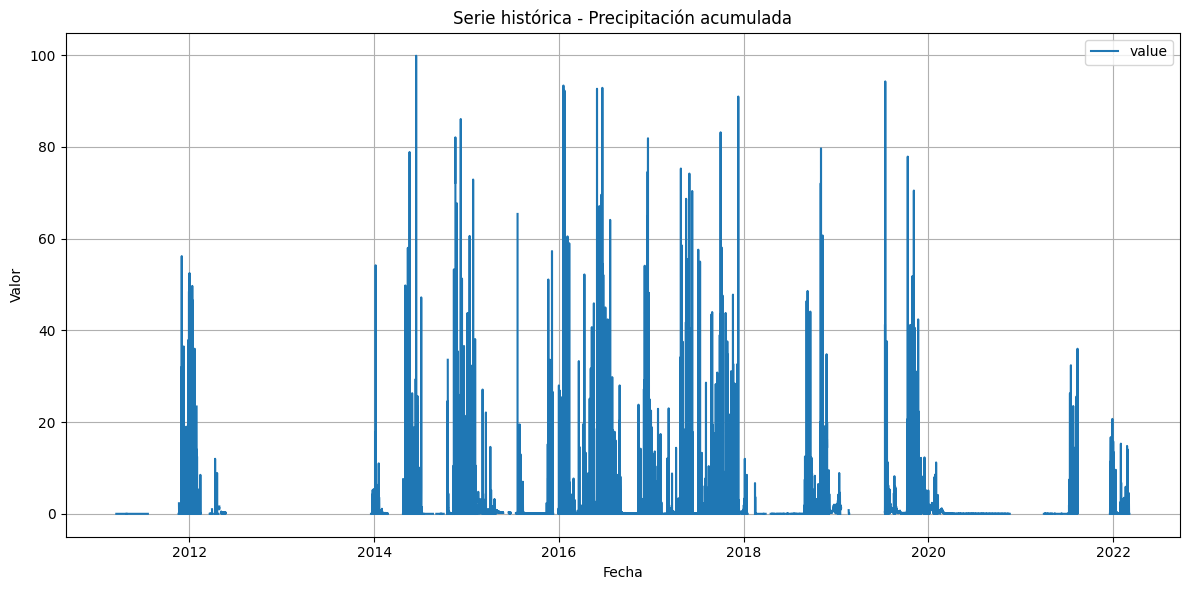

In [12]:
# Remuestreo condicional

# Función para eliminar grupos con más de un porcentaje de NaN
def custom_resample(group, nan_threshold=0.2):
    nan_ratio = group.isna().sum() / len(group)
    return group.sum() if nan_ratio < nan_threshold else np.nan

# Resampleo con diferentes períodos de agregación
red_mpomm_serie_3h = red_mpomm_serie.resample('3h').apply(lambda g: custom_resample(g, nan_threshold=0.2))
print('Reporte de datos NaN y/o null en la serie actual: ')
print(red_mpomm_serie_3h.isnull().sum(),'\n')

lower_bound = 0
upper_bound = 100
# Reemplazar outliers con NaN
red_mpomm_serie_3h['value'] = red_mpomm_serie_3h['value'].where((red_mpomm_serie_3h['value'] >= lower_bound) & (red_mpomm_serie_3h['value'] <= upper_bound), np.nan)

# --- GRAFICAR ---
plt.figure(figsize=(12, 6))
plt.plot(red_mpomm_serie_3h, label=red_mpomm_serie_3h.columns[0])
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.title('Serie histórica - Precipitación acumulada')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Serie MSWEB

Se realiza la obtencion de la matriz de datos de la base de datos global y se maneja los datos ausentes

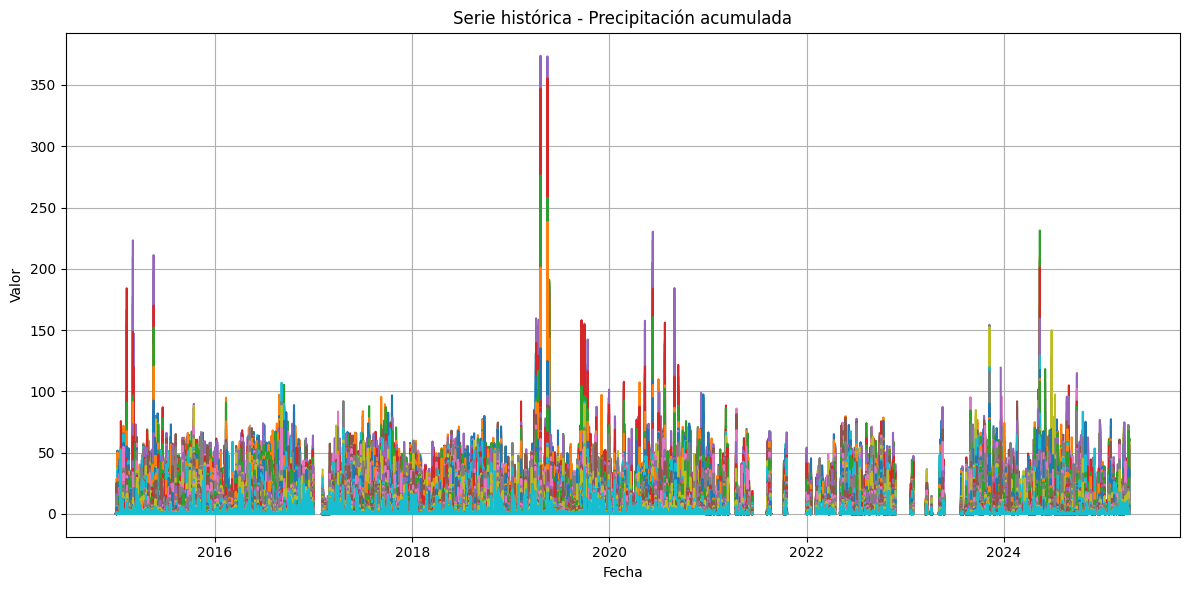

Reporte de datos NaN por columna:
lat_4.45_lon_-79.65    6392
lat_4.45_lon_-79.55    6392
lat_4.45_lon_-79.45    6392
lat_4.45_lon_-79.35    6392
lat_4.45_lon_-79.25    6392
                       ... 
lat_1.55_lon_-77.15    6392
lat_1.55_lon_-77.05    6392
lat_1.55_lon_-76.95    6392
lat_1.55_lon_-76.85    6392
lat_1.55_lon_-76.75    6392
Length: 900, dtype: int64


lat_4.45_lon_-79.65  lat_4.45_lon_-79.55  \
2015-01-01 00:00:00             0.187500             0.125000   
2015-01-01 03:00:00             0.000000             0.000000   
2015-01-01 06:00:00             0.750000             0.250000   
2015-01-01 09:00:00             0.875000             2.062500   
2015-01-01 12:00:00             0.312500             0.062500   
...                                  ...                  ...   
2025-04-10 03:00:00             0.000005             0.000005   
2025-04-10 06:00:00             0.000002             0.045926   
2025-04-10 09:00:00             2.855390             3.819507   
2025-04-10 12:00:00            14.312798            12.351158   
2025-04-10 15:00:00             1.224085             2.365957   

                     lat_4.45_lon_-79.45  lat_4.45_lon_-79.35  \
2015-01-01 00:00:00             0.125000             0.062500   
2015-01-01 03:00:00             0.000000             0.062500   
2015-01-01 06:00:00             0.250000             0.250000   
2015-01-01 09:00:00             0.750000             0.500000   
2015-01-01 12:00:00             0.062500             0.000000   
...                                  ...                  ...   
2025-04-10 03:00:00             0.000003             0.000008   
2025-04-10 06:00:00             0.045625             0.737009   
2025-04-10 09:00:00             3.665368             3.473697   
2025-04-10 12:00:00            10.373526             7.099061   
2025-04-10 15:00:00             2.365957             4.063155   

                     lat_4.45_lon_-79.25  lat_4.45_lon_-79.15  \
2015-01-01 00:00:00             0.062500             0.062500   
2015-01-01 03:00:00             0.062500             0.062500   
2015-01-01 06:00:00             0.250000             0.250000   
2015-01-01 09:00:00             0.500000             0.562500   
2015-01-01 12:00:00             0.125000             0.125000   
...                                  ...                  ...   
2025-04-10 03:00:00             0.000003             0.000004   
2025-04-10 06:00:00             0.725790             0.735826   
2025-04-10 09:00:00             3.227715             3.066792   
2025-04-10 12:00:00             5.068276             5.431098   
2025-04-10 15:00:00             4.063153             4.189662   

                     lat_4.45_lon_-79.05  lat_4.45_lon_-78.95  \
2015-01-01 00:00:00             0.062500             0.062500   
2015-01-01 03:00:00             0.062500             0.062500   
2015-01-01 06:00:00             0.312500             0.312500   
2015-01-01 09:00:00             0.562500             0.562500   
2015-01-01 12:00:00             0.062500             0.062500   
...                                  ...                  ...   
2025-04-10 03:00:00             0.503665             0.489420   
2025-04-10 06:00:00             1.969025             1.956838   
2025-04-10 09:00:00             2.351255             2.126727   
2025-04-10 12:00:00             6.689415             6.839353   
2025-04-10 15:00:00             6.569946             6.522150   

                     lat_4.45_lon_-78.85  lat_4.45_lon_-78.75  ...  \
2015-01-01 00:00:00             0.125000             0.125000  ...   
2015-01-01 03:00:00             0.062500             0.062500  ...   
2015-01-01 06:00:00             0.250000             0.250000  ...   
2015-01-01 09:00:00             0.562500             0.562500  ...   
2015-01-01 12:00:00             0.125000             0.062500  ...   
...                                  ...                  ...  ...   
2025-04-10 03:00:00             0.796617             0.764528  ...   
2025-04-10 06:00:00             2.049899             1.958466  ...   
2025-04-10 09:00:00             1.060263             1.025131  ...   
2025-04-10 12:00:00             8.688954             9.756664  ...   
2025-04-10 15:00:00            17.676631            17.742767  ...   

                     lat_1.55_lon_-77.65  lat_1.55_lon_-

In [13]:
import pandas as pd

# Cargar el CSV y parsear la columna de fecha como datetime
msweb_serie = pd.read_csv(
    r"E:\074-Diego Rengifo 2025\datasience\precipitacion\db\MSWEP-GloH2O\csv-3h\precipitacion igo radius(2.962, -78.173).csv",
    parse_dates=['dates'],   # reemplaza 'datetime' con el nombre real de tu columna de fecha
    index_col='dates'        # establecer la columna como índice
)


# --- Preprocesamiento: Agregacion temporal ---
if not msweb_serie.empty:
    msweb_serie.index= pd.to_datetime(msweb_serie.index)

    # Paso 2: Crear una serie con índice completo con frecuencia cada 3 horas
    start = msweb_serie.index.min()
    end = msweb_serie.index.max()
    full_index = pd.date_range(start=start, end=end, freq='3h')

    # Paso 3: Reindexar para insertar NaN donde faltan datos
    msweb_serie_with_nans = msweb_serie.reindex(full_index)
    
    # --- GRAFICAR ---
    plt.figure(figsize=(12, 6))
    plt.plot(msweb_serie_with_nans, label=msweb_serie.columns[0])
    plt.xlabel('Fecha')
    plt.ylabel('Valor')
    plt.title('Serie histórica - Precipitación acumulada')
    plt.grid(True)
    #plt.legend()
    plt.tight_layout()
    plt.show()

    # Reporte de NaNs
print('Reporte de datos NaN por columna:')
print(msweb_serie_with_nans.isnull().sum())
msweb_serie_with_nans



# Dataset

Se realiza la union de la informacion en un dataset, en este añadimos datos de la redmpomm y de la base de datos global, en las marcas de tiempo que coincidan, con el fin de unificar y procesar los datos de manera mas optima.


In [14]:
# Asegurarse de que el índice de todos los DataFrames sea datetime sin zona horaria
msweb_serie.index = pd.to_datetime(msweb_serie.index).tz_localize(None)
red_mpomm_serie_3h.index = pd.to_datetime(red_mpomm_serie_3h.index).tz_localize(None)

# Convertir la serie objetivo en DataFrame si no lo es
serie_red = red_mpomm_serie_3h[['value']].copy()

# Renombrar columnas de msweb_serie con un prefijo claro
msweb_renamed = msweb_serie.copy()
msweb_renamed.columns = [f'precipitation_{i+1}' for i in range(len(msweb_serie.columns))]

# Unir todo en un solo DataFrame usando concat (más eficiente que múltiples joins)
dataset = pd.concat([serie_red, msweb_renamed], axis=1)

# Reporte de NaNs
print('Reporte de datos NaN por columna:')
print(dataset.isnull().sum())

# Mostrar primeras filas
print(dataset.head())


Reporte de datos NaN por columna:
value                17646
precipitation_1      13722
precipitation_2      13722
precipitation_3      13722
precipitation_4      13722
                     ...  
precipitation_896    13722
precipitation_897    13722
precipitation_898    13722
precipitation_899    13722
precipitation_900    13722
Length: 901, dtype: int64
                     value  precipitation_1  precipitation_2  precipitation_3  \
2011-03-18 03:00:00    NaN              NaN              NaN              NaN   
2011-03-18 06:00:00    NaN              NaN              NaN              NaN   
2011-03-18 09:00:00    NaN              NaN              NaN              NaN   
2011-03-18 12:00:00    NaN              NaN              NaN              NaN   
2011-03-18 15:00:00    NaN              NaN              NaN              NaN   

                     precipitation_4  precipitation_5  precipitation_6  \
2011-03-18 03:00:00              NaN              NaN              NaN   
2011-03-

In [15]:
# Filtrar todas las columnas de precipitación (excluyendo la serie objetivo)
precip_cols = [col for col in dataset.columns if col.startswith('precipitation_')]

# Encontrar el primer índice donde al menos una columna de precipitación tiene un valor no nulo
non_null_mask = dataset[precip_cols].notnull().any(axis=1)
start_index = dataset[non_null_mask].index.min()
end_index = dataset.iloc[:, 0].last_valid_index()

# Filtrar el DataFrame desde ese índice en adelante
filtered_dataset = dataset.loc[start_index:end_index]

# Verificar resultado
print(f"Primer dato válido en al menos una columna de precipitación: {start_index}")
filtered_dataset


Primer dato válido en al menos una columna de precipitación: 2015-01-01 00:00:00


value  precipitation_1  precipitation_2  precipitation_3  \
2015-01-01 00:00:00    0.0         0.187500         0.125000         0.125000   
2015-01-01 03:00:00    0.0         0.000000         0.000000         0.000000   
2015-01-01 06:00:00    0.0         0.750000         0.250000         0.250000   
2015-01-01 09:00:00    2.1         0.875000         2.062500         0.750000   
2015-01-01 12:00:00    2.6         0.312500         0.062500         0.062500   
...                    ...              ...              ...              ...   
2022-03-04 15:00:00    0.0         0.000236         0.000891         0.000896   
2022-03-04 18:00:00    0.0         0.000234         0.000682         0.000684   
2022-03-04 21:00:00    0.0         0.000003         0.000445         0.000445   
2022-03-05 00:00:00    0.0         0.003415         0.017918         0.011534   
2022-03-05 03:00:00    0.0         0.538992         0.490384         0.482817   

                     precipitation_4  precipitation_5  precipitation_6  \
2015-01-01 00:00:00         0.062500         0.062500         0.062500   
2015-01-01 03:00:00         0.062500         0.062500         0.062500   
2015-01-01 06:00:00         0.250000         0.250000         0.250000   
2015-01-01 09:00:00         0.500000         0.500000         0.562500   
2015-01-01 12:00:00         0.000000         0.125000         0.125000   
...                              ...              ...              ...   
2022-03-04 15:00:00         0.004363         0.004342         0.004363   
2022-03-04 18:00:00         0.001366         0.001361         0.001360   
2022-03-04 21:00:00         0.001367         0.001356         0.001357   
2022-03-05 00:00:00         0.010674         0.010533         0.003622   
2022-03-05 03:00:00         0.506236         0.495538         0.503445   

                     precipitation_7  precipitation_8  precipitation_9  ...  \
2015-01-01 00:00:00         0.062500         0.062500         0.125000  ...   
2015-01-01 03:00:00         0.062500         0.062500         0.062500  ...   
2015-01-01 06:00:00         0.312500         0.312500         0.250000  ...   
2015-01-01 09:00:00         0.562500         0.562500         0.562500  ...   
2015-01-01 12:00:00         0.062500         0.062500         0.125000  ...   
...                              ...              ...              ...  ...   
2022-03-04 15:00:00         0.009945         0.009850         0.016743  ...   
2022-03-04 18:00:00         0.005478         0.005439         0.019731  ...   
2022-03-04 21:00:00         0.001802         0.001791         0.000445  ...   
2022-03-05 00:00:00         0.001106         0.000676         0.001340  ...   
2022-03-05 03:00:00         0.549130         0.541404         0.356779  ...   

                     precipitation_891  precipitation_892  precipitation_893  \
2015-01-01 00:00:00           0.062500           0.062500           0.000000   
2015-01-01 03:00:00           0.062500           0.062500           0.125000   
2015-01-01 06:00:00           0.062500           0.000000           0.000000   
2015-01-01 09:00:00           0.000000           0.000000           0.000000   
2015-01-01 12:00:00           0.000000           0.000000           0.187500   
...                                ...                ...                ...   
2022-03-04 15:00:00           0.526628           0.994633           0.831301   
2022-03-04 18:00:00           1.830046           2.586128           2.191118   
2022-03-04 21:00:00           2.117804           3.413168           3.009036   
2022-03-05 00:00:00           1.605005           1.156381           1.173702   
2022-03-05 03:00:00           1.811325           1.420739           1.660429   

                     precipitation_894  precipitation_895  precipitation_896  \
2015-01-01 00:00:00           0.000000           0.000000           0.062500   
2015-01-01 03:00:00           0.000000           0.000000           0.000000   
2015-01-0

In [36]:
'''import numpy as np

# Copia del DataFrame original
df = filtered_dataset.copy()

# Aplicar IQR solo a columnas numéricas
numeric_columns = df.select_dtypes(include=[np.number]).columns

# Filtrar outliers usando IQR en todas las columnas numéricas
for col in numeric_columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    print('limite inferior: ', lower_bound, ' limite superior: ', upper_bound)

    # Reemplazar outliers con NaN
    df[col] = df[col].where((df[col] >= lower_bound) & (df[col] <= upper_bound), np.nan)

# Resultado: DataFrame con NaN en los valores fuera del rango intercuartílico
filtered_iqr_dataset = df
'''
filtered_iqr_dataset = filtered_dataset

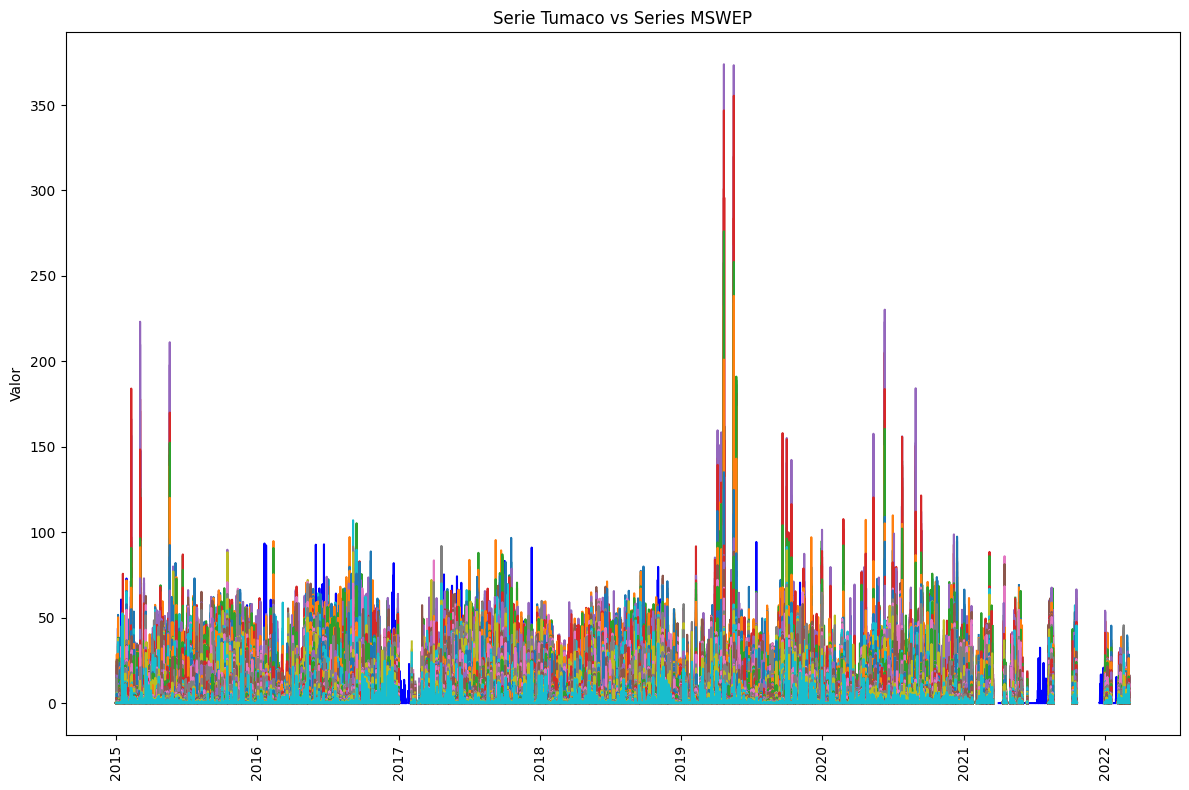

In [37]:
import matplotlib.pyplot as plt


# Crear la figura y el eje
fig, ax = plt.subplots(figsize=(12, 8), sharex=True)

# Graficar la serie objetivo
ax.plot(filtered_iqr_dataset.index, filtered_iqr_dataset['value'], label="Tumaco", color="blue")

# Graficar todas las columnas de precipitación con colores automáticos
for col in precip_cols:
    ax.plot(filtered_iqr_dataset.index, filtered_iqr_dataset[col], label=col)

# Configurar título y etiquetas
ax.set_title('Serie Tumaco vs Series MSWEP')
ax.set_ylabel('Valor')
#ax.legend(loc='upper left')

# Ajustar diseño y mostrar
plt.xticks(rotation='vertical')
plt.tight_layout()
plt.show()


In [53]:
filtered_iqr_dataset.describe()

value  precipitation_1  precipitation_2  precipitation_3  \
count  15608.000000     18319.000000     18319.000000     18319.000000   
mean       1.047988         1.332118         1.376800         1.377534   
std        5.099862         3.184608         3.106483         3.117981   
min        0.000000         0.000000         0.000000         0.000000   
25%        0.000000         0.062500         0.062500         0.062500   
50%        0.000000         0.312500         0.375000         0.375000   
75%        0.200000         1.312500         1.437500         1.437500   
max       94.300000        58.919801        45.187500        46.937500   

       precipitation_4  precipitation_5  precipitation_6  precipitation_7  \
count     18319.000000     18319.000000     18319.000000     18319.000000   
mean          1.361949         1.359209         1.404704         1.521451   
std           3.078240         3.082138         3.183117         3.297756   
min           0.000000         0.000000         0.000000         0.000000   
25%           0.062500         0.062500         0.062500         0.062500   
50%           0.372582         0.363122         0.375000         0.375000   
75%           1.375000         1.375000         1.375000         1.614534   
max          45.437500        44.187500        48.750000        52.312500   

       precipitation_8  precipitation_9  ...  precipitation_892  \
count     18319.000000     18319.000000  ...       18319.000000   
mean          1.524411         1.530389  ...           0.627330   
std           3.292678         3.451583  ...           1.492728   
min           0.000000         0.000000  ...           0.000000   
25%           0.062500         0.062500  ...           0.000000   
50%           0.375000         0.375000  ...           0.125000   
75%           1.625000         1.500000  ...           0.500000   
max          51.875000        54.875000  ...          25.312500   

       precipitation_893  precipitation_894  precipitation_895  \
count       18319.000000       18319.000000       18319.000000   
mean            0.609623           0.611651           0.633458   
std             1.535508           1.605369           1.682187   
min             0.000000           0.000000           0.000000   
25%             0.000000           0.000000           0.000000   
50%             0.062500           0.062500           0.062500   
75%             0.500000           0.437500           0.437500   
max            28.375000          31.000000          30.375000   

       precipitation_896  precipitation_897  precipitation_898  \
count       18319.000000       18319.000000       18319.000000   
mean            0.642012           0.578440           0.626029   
std             1.718737           1.653572           1.718098   
min             0.000000           0.000000           0.000000   
25%             0.000000           0.000000           0.000000   
50%             0.062500           0.062500           0.062500   
75%             0.437500           0.375000           0.437500   
max            32.187500          37.500000          29.875000   

       precipitation_899  precipitation_900     imputados  
count       18319.000000       18319.000000  19721.000000  
mean            0.691482           0.685359      1.185216  
std             1.935650           1.907932      4.891498  
min             0.000000           0.000000      0.000000  
25%             0.000000           0.000000      0.000000  
50%             0.085600           0.125000      0.000000  
75%             0.500000           0.500000      0.300000  
max            54.437500          52.437500     94.300000  

[8 rows x 902 columns]

In [38]:
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor


In [39]:
precipNotNan = filtered_iqr_dataset.dropna()
print('Reporte de datos NaN por columna:')
print(precipNotNan.isnull().sum())
precipNotNan


Reporte de datos NaN por columna:
value                0
precipitation_1      0
precipitation_2      0
precipitation_3      0
precipitation_4      0
                    ..
precipitation_896    0
precipitation_897    0
precipitation_898    0
precipitation_899    0
precipitation_900    0
Length: 901, dtype: int64


value  precipitation_1  precipitation_2  precipitation_3  \
2015-01-01 00:00:00    0.0         0.187500         0.125000         0.125000   
2015-01-01 03:00:00    0.0         0.000000         0.000000         0.000000   
2015-01-01 06:00:00    0.0         0.750000         0.250000         0.250000   
2015-01-01 09:00:00    2.1         0.875000         2.062500         0.750000   
2015-01-01 12:00:00    2.6         0.312500         0.062500         0.062500   
...                    ...              ...              ...              ...   
2022-03-04 15:00:00    0.0         0.000236         0.000891         0.000896   
2022-03-04 18:00:00    0.0         0.000234         0.000682         0.000684   
2022-03-04 21:00:00    0.0         0.000003         0.000445         0.000445   
2022-03-05 00:00:00    0.0         0.003415         0.017918         0.011534   
2022-03-05 03:00:00    0.0         0.538992         0.490384         0.482817   

                     precipitation_4  precipitation_5  precipitation_6  \
2015-01-01 00:00:00         0.062500         0.062500         0.062500   
2015-01-01 03:00:00         0.062500         0.062500         0.062500   
2015-01-01 06:00:00         0.250000         0.250000         0.250000   
2015-01-01 09:00:00         0.500000         0.500000         0.562500   
2015-01-01 12:00:00         0.000000         0.125000         0.125000   
...                              ...              ...              ...   
2022-03-04 15:00:00         0.004363         0.004342         0.004363   
2022-03-04 18:00:00         0.001366         0.001361         0.001360   
2022-03-04 21:00:00         0.001367         0.001356         0.001357   
2022-03-05 00:00:00         0.010674         0.010533         0.003622   
2022-03-05 03:00:00         0.506236         0.495538         0.503445   

                     precipitation_7  precipitation_8  precipitation_9  ...  \
2015-01-01 00:00:00         0.062500         0.062500         0.125000  ...   
2015-01-01 03:00:00         0.062500         0.062500         0.062500  ...   
2015-01-01 06:00:00         0.312500         0.312500         0.250000  ...   
2015-01-01 09:00:00         0.562500         0.562500         0.562500  ...   
2015-01-01 12:00:00         0.062500         0.062500         0.125000  ...   
...                              ...              ...              ...  ...   
2022-03-04 15:00:00         0.009945         0.009850         0.016743  ...   
2022-03-04 18:00:00         0.005478         0.005439         0.019731  ...   
2022-03-04 21:00:00         0.001802         0.001791         0.000445  ...   
2022-03-05 00:00:00         0.001106         0.000676         0.001340  ...   
2022-03-05 03:00:00         0.549130         0.541404         0.356779  ...   

                     precipitation_891  precipitation_892  precipitation_893  \
2015-01-01 00:00:00           0.062500           0.062500           0.000000   
2015-01-01 03:00:00           0.062500           0.062500           0.125000   
2015-01-01 06:00:00           0.062500           0.000000           0.000000   
2015-01-01 09:00:00           0.000000           0.000000           0.000000   
2015-01-01 12:00:00           0.000000           0.000000           0.187500   
...                                ...                ...                ...   
2022-03-04 15:00:00           0.526628           0.994633           0.831301   
2022-03-04 18:00:00           1.830046           2.586128           2.191118   
2022-03-04 21:00:00           2.117804           3.413168           3.009036   
2022-03-05 00:00:00           1.605005           1.156381           1.173702   
2022-03-05 03:00:00           1.811325           1.420739           1.660429   

                     precipitation_894  precipitation_895  precipitation_896  \
2015-01-01 00:00:00           0.000000           0.000000           0.062500   
2015-01-01 03:00:00           0.000000           0.000000           0.000000   
2015-01-0

In [40]:
# Definir variables independientes (X) y dependiente (y)
xTrain = precipNotNan.drop(columns=['value'])
yTrain = precipNotNan['value'].values.flatten()
# Guardar columnas para usarlas después
columns_for_model = xTrain.columns

# Mostrar primeras 10 filas
print(xTrain.head(10))
print(yTrain[:10])

                     precipitation_1  precipitation_2  precipitation_3  \
2015-01-01 00:00:00           0.1875           0.1250           0.1250   
2015-01-01 03:00:00           0.0000           0.0000           0.0000   
2015-01-01 06:00:00           0.7500           0.2500           0.2500   
2015-01-01 09:00:00           0.8750           2.0625           0.7500   
2015-01-01 12:00:00           0.3125           0.0625           0.0625   
2015-01-01 15:00:00           0.0000           0.0000           0.0000   
2015-01-01 18:00:00           0.0000           0.0000           0.0000   
2015-01-01 21:00:00           0.0625           0.1250           0.1250   
2015-01-02 00:00:00           0.1250           0.2500           0.2500   
2015-01-02 03:00:00           0.1250           0.1875           0.1875   

                     precipitation_4  precipitation_5  precipitation_6  \
2015-01-01 00:00:00           0.0625           0.0625           0.0625   
2015-01-01 03:00:00           0.0625 

In [41]:
scaler = StandardScaler().fit(xTrain)
xTrainScaled = scaler.transform(xTrain)
print(xTrainScaled[:10])

[[-0.36321512 -0.41148195 -0.40658407 ... -0.35703834 -0.35300239
  -0.35205136]
 [-0.42306606 -0.45266538 -0.44686477 ... -0.35703834 -0.35300239
  -0.35205136]
 [-0.1836623  -0.37029853 -0.36630336 ... -0.35703834 -0.35300239
  -0.35205136]
 ...
 [-0.40311575 -0.41148195 -0.40658407 ... -0.35703834 -0.35300239
  -0.35205136]
 [-0.38316544 -0.37029853 -0.36630336 ... -0.35703834 -0.35300239
  -0.35205136]
 [-0.38316544 -0.39089024 -0.38644371 ... -0.35703834 -0.35300239
  -0.35205136]]


In [42]:
#check scaler
print(xTrainScaled.mean(axis=0))
print(xTrainScaled.std(axis=0))

[-2.00068347e-17  3.20109356e-17  1.40047843e-17  8.00273390e-18
  1.60054678e-17  1.40047843e-17 -1.40047843e-17  2.00068347e-18
  1.40047843e-17  2.30078599e-17  2.00068347e-18  1.90064930e-17
  8.00273390e-18  4.00136695e-18  1.20041008e-17  5.00170868e-18
 -2.00068347e-17 -3.80129860e-17 -6.00205042e-18 -4.20143530e-17
  1.20041008e-17  1.60054678e-17 -4.00136695e-18 -2.00068347e-18
 -1.30044426e-17  5.60191373e-17  2.00068347e-17 -6.00205042e-18
  5.20177703e-17  3.80129860e-17 -3.60123025e-17  1.20041008e-17
  2.40082017e-17  2.00068347e-18  1.00034174e-17  4.00136695e-18
 -2.60088852e-17 -2.00068347e-17  1.80061513e-17  2.20075182e-17
 -1.60054678e-17 -1.00034174e-17  4.00136695e-18  2.50085434e-17
 -1.70058095e-17 -6.00205042e-18 -8.00273390e-18  0.00000000e+00
 -1.20041008e-17 -3.80129860e-17 -8.00273390e-18  4.00136695e-17
 -1.60054678e-17 -1.25042717e-17 -1.20041008e-17  3.00102521e-17
 -1.20041008e-17  1.90064930e-17  0.00000000e+00  0.00000000e+00
 -8.00273390e-18 -5.40184

In [43]:
# Ajustar modelo MLPRegressor
regr = MLPRegressor(
    hidden_layer_sizes=(100,),  # Una capa oculta de 100 neuronas
    activation='relu',
    solver='adam',
    alpha=0.0001,
    batch_size='auto',
    learning_rate='constant',
    max_iter=5000,
    random_state=1
).fit(xTrainScaled, yTrain)

# --- Prueba ---
# Seleccionar todas las columnas de precipitación y eliminar filas con NaN
xTest = filtered_iqr_dataset[precip_cols].dropna()
xTestScaled = scaler.transform(xTest.values)

# Mostrar resumen
print(xTest.describe())
print(xTestScaled[:10])

e:\074-Diego Rengifo 2025\datasience\precipitacion\bigdata\bigdata\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names



       precipitation_1  precipitation_2  precipitation_3  precipitation_4  \
count     18319.000000     18319.000000     18319.000000     18319.000000   
mean          1.332118         1.376800         1.377534         1.361949   
std           3.184608         3.106483         3.117981         3.078240   
min           0.000000         0.000000         0.000000         0.000000   
25%           0.062500         0.062500         0.062500         0.062500   
50%           0.312500         0.375000         0.375000         0.372582   
75%           1.312500         1.437500         1.437500         1.375000   
max          58.919801        45.187500        46.937500        45.437500   

       precipitation_5  precipitation_6  precipitation_7  precipitation_8  \
count     18319.000000     18319.000000     18319.000000     18319.000000   
mean          1.359209         1.404704         1.521451         1.524411   
std           3.082138         3.183117         3.297756         3.292678  

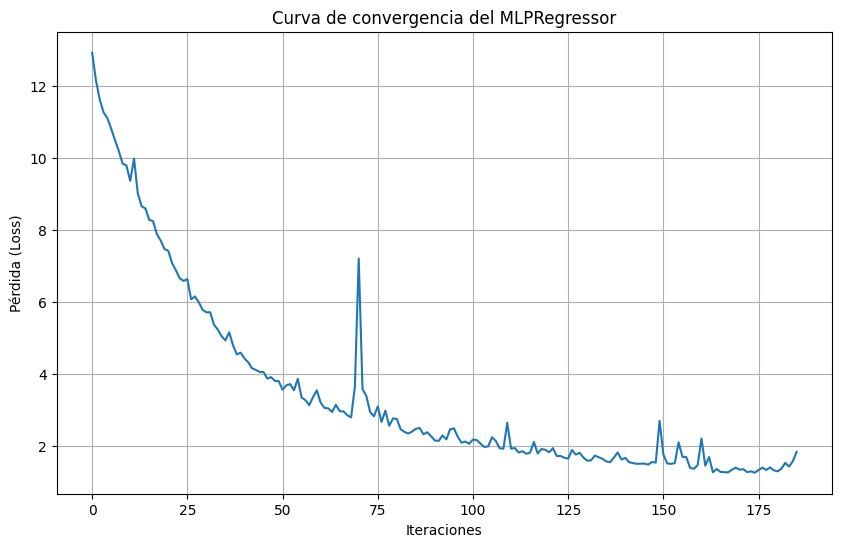

In [44]:
import matplotlib.pyplot as plt

# Graficar la pérdida por iteración
plt.figure(figsize=(10, 6))
plt.plot(regr.loss_curve_)
plt.title("Curva de convergencia del MLPRegressor")
plt.xlabel("Iteraciones")
plt.ylabel("Pérdida (Loss)")
plt.grid(True)
plt.show()

In [45]:
from sklearn.model_selection import cross_val_score

# Validación cruzada de 5 pliegues (k-fold)
scores = cross_val_score(
    regr, xTrainScaled, yTrain, scoring='neg_mean_squared_error', cv=5
)

print("Cross-validation MSE scores:", -scores)
print("Cross-validation MSE promedio:", -scores.mean())


Cross-validation MSE scores: [39.56820052 49.61953841 46.77317917 39.47762268 22.26530191]
Cross-validation MSE promedio: 39.54076853793695


In [46]:
# --- Predicción ---
yPredict = regr.predict(xTestScaled)
print(yPredict[:10])

[ 0.07398749  0.17657588  0.83175559  1.08760457  0.12063273 -0.85624493
 -3.02536085 -2.78756675 -1.93933871 -1.09678784]


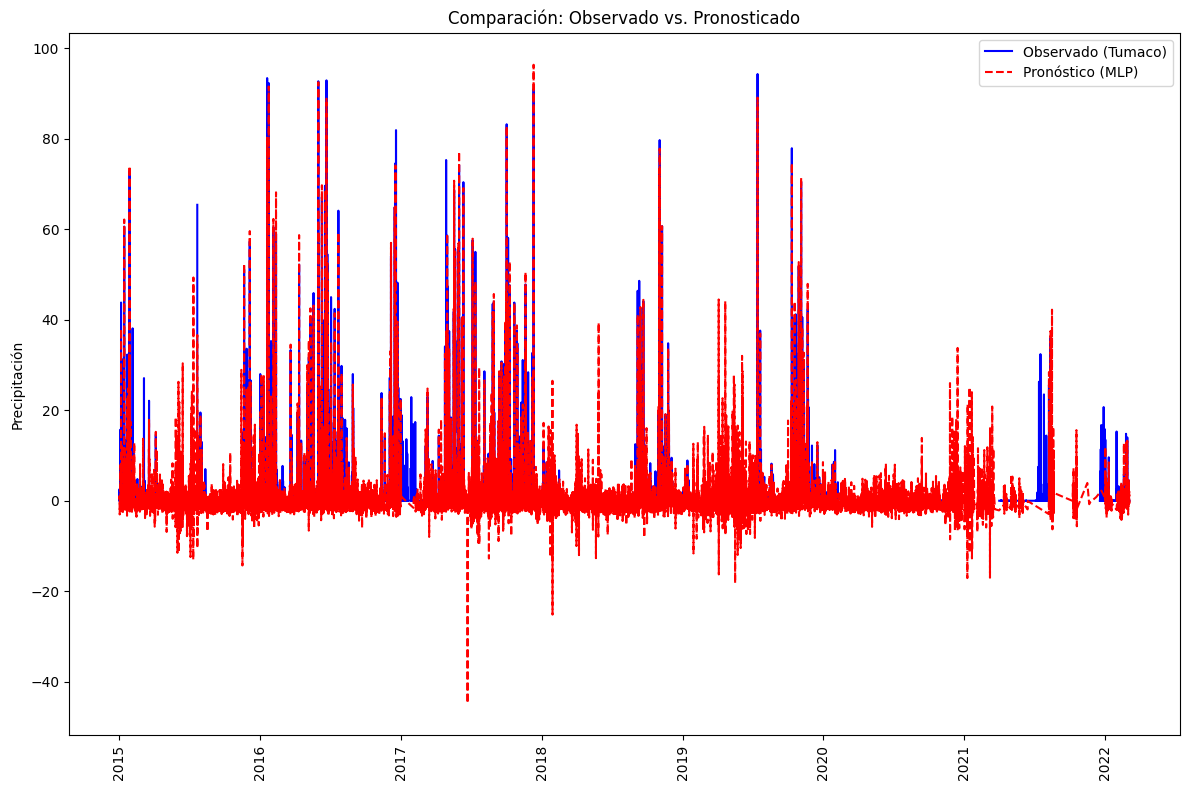

In [47]:
# --- Visualización de comparación ---
fig, ax = plt.subplots(figsize=(12, 8), sharex=True, sharey=True)
ax.plot(filtered_iqr_dataset.index, filtered_iqr_dataset['value'], label='Observado (Tumaco)', color='blue')
ax.plot(xTest.index, yPredict, label='Pronóstico (MLP)', color='red', linestyle='--')
ax.set_title('Comparación: Observado vs. Pronosticado')
ax.set_ylabel('Precipitación')
ax.legend()
plt.xticks(rotation='vertical')
plt.tight_layout()
plt.show()

C:\Users\drengifo\AppData\Local\Temp\ipykernel_38784\2819888244.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



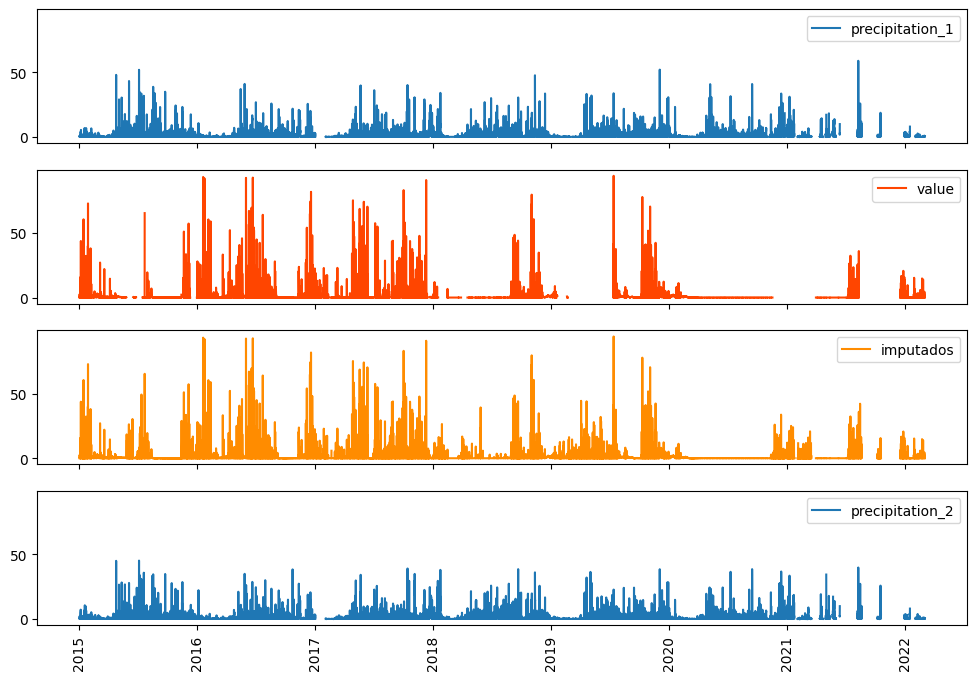

Reporte de datos NaN por columna:
value                5354
precipitation_1      2643
precipitation_2      2643
precipitation_3      2643
precipitation_4      2643
                     ... 
precipitation_897    2643
precipitation_898    2643
precipitation_899    2643
precipitation_900    2643
imputados            1241
Length: 902, dtype: int64


In [48]:
# Crear la nueva columna
filtered_iqr_dataset['imputados'] = np.nan

# Crear máscara
missing_mask = (
    filtered_iqr_dataset['value'].isna() &
    filtered_iqr_dataset[columns_for_model].notna().all(axis=1)
)

# Transformar y predecir
to_impute = filtered_iqr_dataset.loc[missing_mask, columns_for_model]
to_impute_scaled = scaler.transform(to_impute)
predicted_values = regr.predict(to_impute_scaled)
predicted_values = np.where(predicted_values < 0, 0, predicted_values)
filtered_iqr_dataset.loc[missing_mask, 'imputados'] = predicted_values

# Copiar los valores originales donde existen
filtered_iqr_dataset.loc[filtered_iqr_dataset['value'].notna(), 'imputados'] = filtered_iqr_dataset['value']

#show original and filled values
fig, axs=plt.subplots(4,1,figsize=(12,8),sharex=True,sharey=True)
axs[0].plot(filtered_iqr_dataset.index,filtered_iqr_dataset['precipitation_1'],label='precipitation_1')
axs[0].legend()
axs[1].plot(filtered_iqr_dataset.index,filtered_iqr_dataset['value'],label='value',color='orangered')
axs[1].legend()
axs[2].plot(filtered_iqr_dataset.index,filtered_iqr_dataset['imputados'],label='imputados',color='darkorange')
axs[2].legend()
axs[3].plot(filtered_iqr_dataset.index,filtered_iqr_dataset['precipitation_2'],label='precipitation_2')
axs[3].legend()
plt.xticks(rotation='vertical')
plt.show()
# Reporte de NaNs
print('Reporte de datos NaN por columna:')
print(filtered_iqr_dataset.isnull().sum())

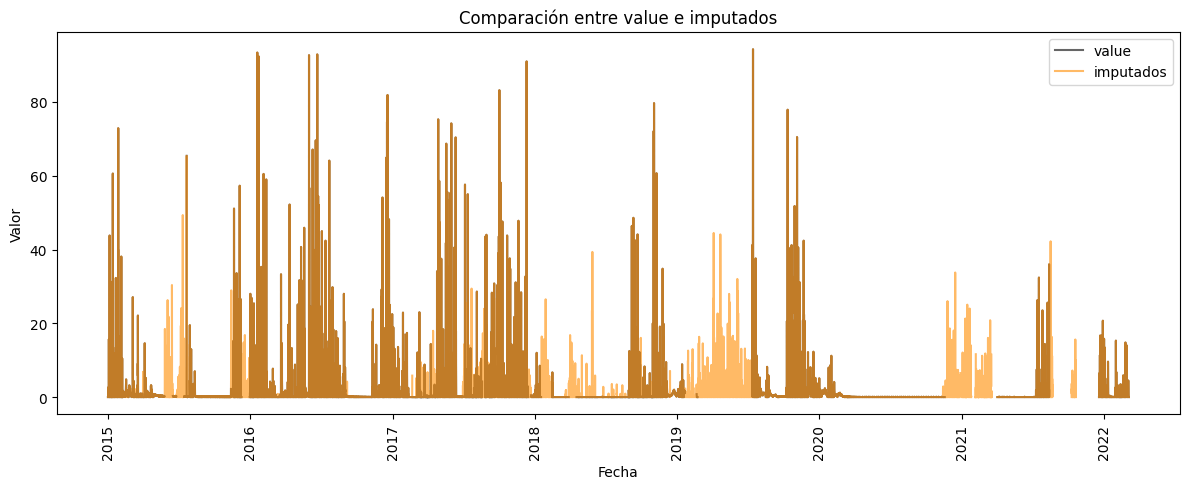

In [49]:
# Mostrar solo 'value' e 'imputados' con transparencia
plt.figure(figsize=(12, 5))
plt.plot(filtered_iqr_dataset.index, filtered_iqr_dataset['value'], label='value', color='black', alpha=0.6)
plt.plot(filtered_iqr_dataset.index, filtered_iqr_dataset['imputados'], label='imputados', color='darkorange', alpha=0.6)
plt.legend()
plt.xticks(rotation='vertical')
plt.title('Comparación entre value e imputados')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.tight_layout()
plt.show()


In [50]:
from graphics_utils.go import multi_line

fig=multi_line(original=filtered_iqr_dataset['value'], imputada=filtered_iqr_dataset['imputados'])
fig.show()

¿Valores nulos restantes? 0


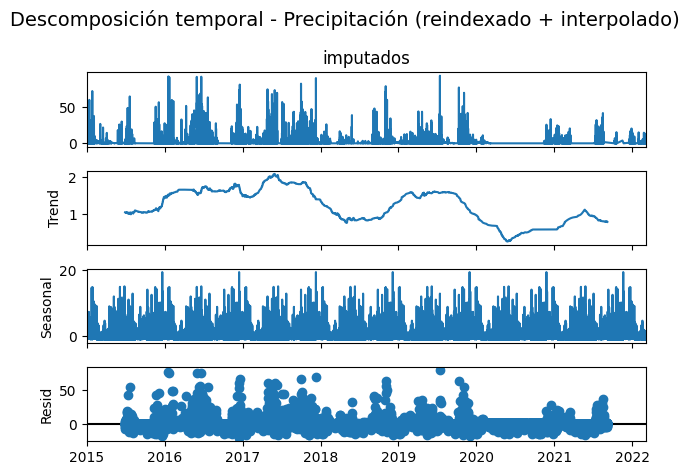

In [51]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# 1. Selecciona la columna
precip_clean = filtered_iqr_dataset['imputados'].copy()

# 2. Convierte el índice a datetime si no lo es
precip_clean.index = pd.to_datetime(precip_clean.index)

# 3. Reindexar con frecuencia completa para evitar huecos ocultos
full_index = pd.date_range(start=precip_clean.index.min(), end=precip_clean.index.max(), freq='3h')
precip_clean = precip_clean.reindex(full_index)

# 4. Interpola para evitar NaNs
precip_clean = precip_clean.interpolate(method='linear')

# 5. Confirmar limpieza
print("¿Valores nulos restantes?", precip_clean.isna().sum())

# 6. Descomposición (usamos period=8 para ciclo diario en datos 3H)
decomposition = seasonal_decompose(precip_clean, model='additive', period=8*30*12)
decomposition.plot()
plt.suptitle("Descomposición temporal - Precipitación (reindexado + interpolado)", fontsize=14)
plt.tight_layout()
plt.show()


In [52]:
from statsmodels.tsa.seasonal import seasonal_decompose
import pandas as pd
import plotly.graph_objects as go

# 1. Selección de la columna
precip_clean = filtered_iqr_dataset['imputados'].copy()

# 2. Conversión del índice a datetime
precip_clean.index = pd.to_datetime(precip_clean.index)

# 3. Reindexar con frecuencia completa
full_index = pd.date_range(start=precip_clean.index.min(), end=precip_clean.index.max(), freq='3h')
precip_clean = precip_clean.reindex(full_index)

# 4. Interpolación para NaNs
precip_clean = precip_clean.interpolate(method='linear')

# 5. Verificar valores nulos
print("¿Valores nulos restantes?", precip_clean.isna().sum())

# 6. Descomposición
decomposition = seasonal_decompose(precip_clean, model='additive', two_sided=True,period=8*28*18)

# 7. Visualización con Plotly
fig = go.Figure()

fig.add_trace(go.Scatter(x=precip_clean.index, y=decomposition.observed, name='Observed'))
fig.add_trace(go.Scatter(x=precip_clean.index, y=decomposition.trend, name='Trend'))
fig.add_trace(go.Scatter(x=precip_clean.index, y=decomposition.seasonal, name='Seasonal'))
fig.add_trace(go.Scatter(x=precip_clean.index, y=decomposition.resid, name='Residual'))

fig.update_layout(
    title='Descomposición Temporal - Precipitación (Plotly)',
    xaxis_title='Fecha',
    yaxis_title='Valor',
    height=600,
    legend_title='Componentes',
    template='plotly_white'
)

fig.show()


¿Valores nulos restantes? 0
